# Imports

In [73]:
from numpy.random import seed
seed(888)
import tensorflow as tf
tf.random.set_seed(888)
import os
import numpy as np
from time import strftime
from datetime import date
from PIL import Image
from sklearn.model_selection import train_test_split

# Constants

In [27]:
# define constants
X_TRAIN_PATH = 'MNIST/digit_xtrain.csv'
X_TEST_PATH = 'MNIST/digit_xtest.csv'
Y_TRAIN_PATH = 'MNIST/digit_ytrain.csv'
Y_TEST_PATH = 'MNIST/digit_ytest.csv'

LOGGING_PATH = 'tensorboard_mnist_digit_logs/'

NR_CLASSES = 10
VALIDATION_SIZE = 10000
IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28
CHANNELS = 1
TOTAL_INPUTS = IMAGE_WIDTH*IMAGE_HEIGHT*CHANNELS

# Get the Data

In [30]:
%%time

def import_data():
    y_train_all = np.loadtxt(Y_TRAIN_PATH, delimiter=',', dtype=int)
    y_test = np.loadtxt(Y_TEST_PATH, delimiter=',', dtype=int)
    x_train_all = np.loadtxt(X_TRAIN_PATH, delimiter=',', dtype=int)
    x_test = np.loadtxt(X_TEST_PATH, delimiter=',', dtype=int)
    return y_train_all, y_test, x_train_all, x_test

y_train_all, y_test, x_train_all, x_test = import_data()

CPU times: total: 4.8 s
Wall time: 5.03 s


In [31]:
y_train_all.shape

(60000,)

# EDA

In [32]:
x_train_all.shape

(60000, 784)

In [33]:
x_train_all[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,  18,  18,
       126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,  30,  36,  94, 154, 17

In [14]:
# save sample for testing
# np.savetxt(fname='x_test0_ylabel7.txt', X=[x_test[0]], delimiter= ', ', fmt='%1.2f') 

In [34]:
y_train_all.shape

(60000,)

In [35]:
x_test.shape

(10000, 784)

In [36]:
y_train_all[:5]

array([5, 0, 4, 1, 9])

# Data Preprocessing

In [37]:
def copy_x():
    x_tr = x_train_all.copy()
    x_te = x_test.copy()
    return x_tr, x_te

def copy_y():
    y_tr = y_train_all.copy()
    y_te = y_test.copy()
    return y_tr, y_te


In [38]:
# Re-scale
x_train_all, x_test = copy_x()
x_train_all, x_test = x_train_all / 255.0, x_test / 255.0

#### Convert target values to one-hot encoding

manual one-hot-encoding: we create an identity matrix where size (10 x 10) is equal to the number of classes (1 for each digit, i.e. 10). We then
match each y-value with the corresponding row from the ID matrix, i.e. the value '7' will result in row nr. 7 from the ID matrix --> it will have zeros in every column except the 7th, where the value will be 1.


In [ ]:
y_train_all, y_test = copy_y()

y_train_all = np.eye(NR_CLASSES)[y_train_all]
y_test = np.eye(NR_CLASSES)[y_test]

print(y_train_all.shape)
print(y_test.shape)

### Create validation dataset from training data

In [45]:
X_train, X_val, y_train, y_val = train_test_split(x_train_all, 
                                                  y_train_all, 
                                                  test_size=1/6, 
                                                  random_state=42)

print(X_train.shape)
print(X_val.shape)

# Setup Tensorflow Graph

### Neural Network Architecture

In [50]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

# define hyperparameters
nr_epochs = 50
learning_rate = 1e-3

n_hidden1 = 512
n_hidden2 = 64


# setup model
model = Sequential([
    # First hidden layer with 512 units and ReLU activation
    Dense(n_hidden1, activation='relu', input_shape=(TOTAL_INPUTS,), name='layer_1'),
    
    # Dropout layer with 20% drop rate
    Dropout(rate=0.2, name='dropout_layer'),
    
    # Second hidden layer with 64 units and ReLU activation
    Dense(n_hidden2, activation='relu', name='layer_2'),
    
    # Output layer with NR_CLASSES units and softmax activation
    Dense(NR_CLASSES, activation='softmax', name='out')
])

# Tensorboard Setup

In [51]:
model_name = f'{n_hidden1}-DO-{n_hidden2} LR{learning_rate} E{nr_epochs}'
folder_name = f'{model_name} at {strftime("%H_%M")}'
directory = os.path.join(LOGGING_PATH, folder_name)
abs_path = os.path.abspath(directory)
os.makedirs(abs_path, exist_ok=True)

In [52]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


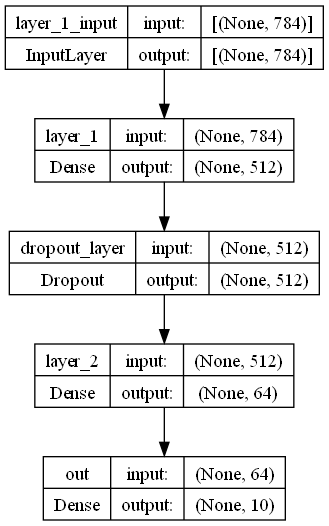

In [53]:
from keras.utils import plot_model
tf.keras.utils.plot_model(model, show_shapes=True)

# Run Session

In [54]:
from tensorflow.keras.callbacks import TensorBoard

# Define TensorBoard callback
tensorboard_callback = TensorBoard(log_dir=abs_path, 
                                   write_graph= True,
                                   write_images= True,
                                   histogram_freq=1)


### Train Model

In [56]:
# Defining the batch size
size_of_batch = 1000

# Fit the model using the training data
# history = model.fit(
model.fit(
    X_train, y_train,
    batch_size=size_of_batch,
    epochs=nr_epochs,
    verbose=1,
    validation_data=(X_val, y_val),
    callbacks=[tensorboard_callback]
)

print('Done training!')

Epoch 1/50
50/50 [==============================] - 2s 26ms/step - loss: 0.6469 - accuracy: 0.8207 - val_loss: 0.2472 - val_accuracy: 0.9293
Epoch 2/50
50/50 [==============================] - 1s 17ms/step - loss: 0.2261 - accuracy: 0.9343 - val_loss: 0.1742 - val_accuracy: 0.9502
Epoch 3/50
50/50 [==============================] - 1s 17ms/step - loss: 0.1644 - accuracy: 0.9529 - val_loss: 0.1370 - val_accuracy: 0.9603
Epoch 4/50
50/50 [==============================] - 1s 19ms/step - loss: 0.1296 - accuracy: 0.9619 - val_loss: 0.1143 - val_accuracy: 0.9675
Epoch 5/50
50/50 [==============================] - 1s 18ms/step - loss: 0.1050 - accuracy: 0.9702 - val_loss: 0.1006 - val_accuracy: 0.9705
Epoch 6/50
50/50 [==============================] - 1s 19ms/step - loss: 0.0892 - accuracy: 0.9735 - val_loss: 0.0898 - val_accuracy: 0.9730
Epoch 7/50
50/50 [==============================] - 1s 22ms/step - loss: 0.0756 - accuracy: 0.9779 - val_loss: 0.0816 - val_accuracy: 0.9742
Epoch 8/50
50

In [57]:
%load_ext tensorboard 

In [58]:
# %tensorboard --logdir="{abs_path}"   # path variable needs to be in brackets and quotes

# Testing and Evaluation

In [77]:
img = Image.open('MNIST/test_img.png')
img

In [78]:
img = Image.open('MNIST/test_img.png')
bw = img.convert('L')   
img_array = np.invert(bw)  
test_img = img_array.ravel().reshape(1, -1) 
prediction = model.predict(test_img)
predicted_class = np.argmax(prediction, axis=1)  

print(f'Prediction for test image is {predicted_class}')

1/1 [==============================] - 0s 36ms/step
Prediction for test image is [2]


In [63]:
img = Image.open('MNIST/test_img.png')

# the following two lines can be useful preprocessing and improve accuracy but may not always be strictly necessary
bw = img.convert('L')   
img_array = np.invert(bw)  

# required input shape - flatten into 1D array and then reshape into 2D array with one row and as many columns as needed (indicated by -1)
# np.ravel() does same thing as: for row in n_dimensional_array, 1_dimensional_array.extend(row)
test_img = img_array.ravel().reshape(1, -1) 

# make prediction
prediction = model.predict(test_img)
predicted_class = np.argmax(prediction, axis=1)  # argmax returns array column with highest value

print(f'Prediction for test image is {predicted_class}')

1/1 [==============================] - 0s 25ms/step
Prediction for test image is [2]


In [61]:
# test accuracy using test set
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f'Accuracy on test set is {test_accuracy:0.2%}')

313/313 [==============================] - 0s 1ms/step - loss: 0.0782 - accuracy: 0.9813
Accuracy on test set is 98.13%


# Save the model

In [75]:
# Save the model
model.save(f'tf_handwriting_recog_model_{str(date.today())}')

INFO:tensorflow:Assets written to: tf_handwriting_recog_model 2023-08-31\assets


In [ ]:
# Load the model
# new_model = tf.keras.models.load_model('tf_handwriting_recog_model_2023-xx-xx')

In [ ]:
# b3.eval(sess)